Apply K-Correction to an LRG spectrum

In [1]:
import pandas as pd
import numpy as np

from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.integrate import quad

from astropy.io import fits
from astropy.table import Table

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Spectrum of the galaxy
data = Table.read('lrg.fits', format='fits')
df = data.to_pandas()
print('Number of rows in spectrum file: ' + str(len(df.index)))
df.head()

Number of rows in spectrum file: 2560


,LAMBDA,FLAMBDA
0,1000.65,0.00001
1,1001.51,0.00001
2,1002.36,0.00001
3,1003.23,0.00001
4,1004.09,0.00001


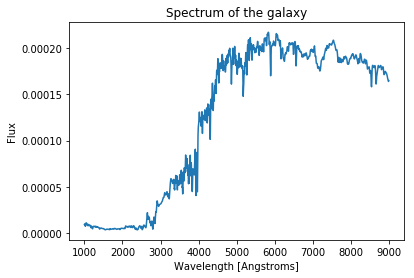

In [3]:
plt.figure()
plt.plot(df['LAMBDA'], df['FLAMBDA'])
plt.title('Spectrum of the galaxy')
plt.xlabel("Wavelength [Angstroms]")
plt.ylabel("Flux")
plt.show()

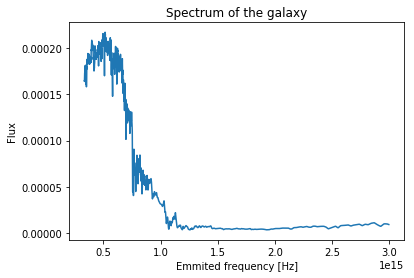

In [4]:
df['FREQUENCY'] = 2.99792458e18 / df['LAMBDA'].values
df.head()
plt.figure()
plt.plot(df['FREQUENCY'], df['FLAMBDA'])
plt.title('Spectrum of the galaxy')
plt.xlabel("Emmited frequency [Hz]")
plt.ylabel("Flux")
plt.show()

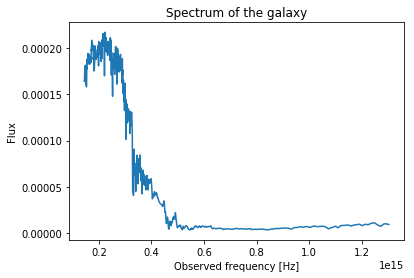

In [5]:
# z arbitrary chosen redshift of the galaxy
z = 1.3
df['OBSERVED_FREQUENCY'] = df['FREQUENCY'].values/(1+z)
df.head()
plt.figure()
plt.plot(df['OBSERVED_FREQUENCY'], df['FLAMBDA'])
plt.title('Spectrum of the galaxy')
plt.xlabel("Observed frequency [Hz]")
plt.ylabel("Flux")
plt.show()

In [6]:
# Comand shell - transmission curves of the bandpasses
print('Number of rows in the g filter transmission file:')
! cat filters/DECam_g.dat | wc -l
passband = pd.read_csv('filters/DECam_g.dat',
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')
passband.head()

Number of rows in the g filter transmission file:
201


,WAVELENGTH,TRANSMISSION
0,3740.0,0.0
1,3750.0,0.0
2,3760.0,0.0
3,3770.0,0.0
4,3780.0,0.0


In [7]:
def read_passband(band):
    """                                                                                                                                                                                                                                                                                                                                                                        
    Read and interpolate filter transmission curves                                                                                                                                                                                                                                                                                                                             

    :param band: the single-letter band identifier                                                                                                                                                                                                                                                                                                                             
    :return: transmisison_frequency: interpolated filter transmission as a function of frequency                                                                                                                                                                                                                                                                               
    :return: transmisison_wavelength: interpolated filter transmission as a function of wavelength                                                                                                                                                                                                                                                                             
    """
    #Target filter file associated with band                                                                                                                                                                                                                                                                                                                                   
    filter_file = 'filters/DECam_{}.dat'.format(band)

    # Read and format filter transmission info                                                                                                                                                                                                                                                                                                                                 
    passband = pd.read_csv(filter_file,
                           names=['WAVELENGTH', 'TRANSMISSION'],
                           delim_whitespace=True, comment='#')

    # Add boundary terms to cover the whole range                                                                                                                                                                                                                                                                                                                              
    passband.loc[passband.shape[0]] = (1.e-1, 0.0)
    passband.loc[passband.shape[0]] = (4.e+4, 0.0)

    # Convert to frequency using speed of light in angstroms                                                                                                                                                                                                                                                                                                                   
    passband['FREQUENCY'] = 2.99792458e18 / passband['WAVELENGTH'].values
    passband['OBSERVED_FREQUENCY'] = passband['FREQUENCY'].values/(1+z)

    # Interpolate and return                                                                                                                                                                                                                                                                                                                                                   
    transmission_frequency = interp1d(passband['FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_wavelength = interp1d(passband['WAVELENGTH'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    transmission_frequency_obs = interp1d(passband['OBSERVED_FREQUENCY'].values, passband['TRANSMISSION'].values, fill_value=0.0)
    
    return transmission_frequency, transmission_wavelength, transmission_frequency_obs

In [8]:
g_transmission_frequency, g_transmission_wavelength, g_transmission_frequency_obs = read_passband('g')
i_transmission_frequency, i_transmission_wavelength, i_transmission_frequency_obs = read_passband('i')
r_transmission_frequency, r_transmission_wavelength, r_transmission_frequency_obs = read_passband('r')
y_transmission_frequency, y_transmission_wavelength, y_transmission_frequency_obs = read_passband('Y')
z_transmission_frequency, z_transmission_wavelength, z_transmission_frequency_obs = read_passband('z')

In [9]:
g_transmission_w = g_transmission_wavelength(df['LAMBDA'].values)
i_transmission_w = i_transmission_wavelength(df['LAMBDA'].values)
r_transmission_w = r_transmission_wavelength(df['LAMBDA'].values)
y_transmission_w = y_transmission_wavelength(df['LAMBDA'].values)
z_transmission_w = z_transmission_wavelength(df['LAMBDA'].values)

g_transmission_f = g_transmission_frequency(df['FREQUENCY'].values)
i_transmission_f = i_transmission_frequency(df['FREQUENCY'].values)
r_transmission_f = r_transmission_frequency(df['FREQUENCY'].values)
y_transmission_f = y_transmission_frequency(df['FREQUENCY'].values)
z_transmission_f = z_transmission_frequency(df['FREQUENCY'].values)

g_transmission_f_o = g_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
i_transmission_f_o = i_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
r_transmission_f_o = r_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
y_transmission_f_o = y_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)
z_transmission_f_o = z_transmission_frequency_obs(df['OBSERVED_FREQUENCY'].values)

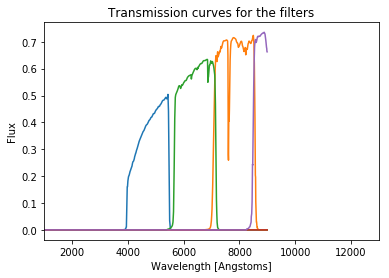

In [10]:
plt.figure()
plt.title('Transmission curves for the filters')
plt.xlim(1000,13000)
plt.plot(df['LAMBDA'].values, g_transmission_w, label='a')
plt.plot(df['LAMBDA'].values, i_transmission_w)
plt.plot(df['LAMBDA'].values, r_transmission_w)
plt.plot(df['LAMBDA'].values, y_transmission_w)
plt.plot(df['LAMBDA'].values, z_transmission_w)
#plt.legend('g')
plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

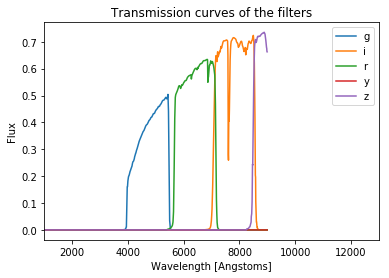

In [11]:
plt.figure()
plt.title('Transmission curves of the filters')
plt.xlim(1000,13000)
plt.plot(df['LAMBDA'].values, g_transmission_w, label='g')
plt.plot(df['LAMBDA'].values, i_transmission_w, label='i')
plt.plot(df['LAMBDA'].values, r_transmission_w, label='r')
plt.plot(df['LAMBDA'].values, y_transmission_w, label='y')
plt.plot(df['LAMBDA'].values, z_transmission_w, label='z')
plt.legend()
plt.xlabel("Wavelength [Angstoms]")
plt.ylabel("Flux")
plt.show()

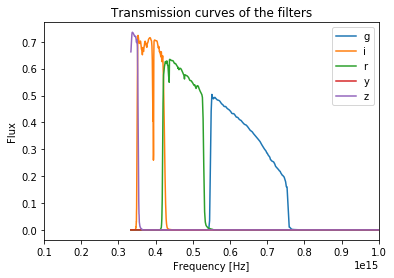

In [12]:
plt.figure()
plt.xlim(1e14,1e15)
plt.title('Transmission curves of the filters')
plt.plot(df['FREQUENCY'].values, g_transmission_f, label='g')
plt.plot(df['FREQUENCY'].values, i_transmission_f, label='i')
plt.plot(df['FREQUENCY'].values, r_transmission_f, label='r')
plt.plot(df['FREQUENCY'].values, y_transmission_f, label='y')
plt.plot(df['FREQUENCY'].values, z_transmission_f, label='z')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Flux")
plt.show()

# Calculation of the k-correction

[Paper with definition and equations for the k-correction](https://arxiv.org/pdf/astro-ph/0210394.pdf)

The equations in this section are not rendering correctly in GitHub, it is neccesary to use nb viewer to see them: [nbviewer link](https://nbviewer.jupyter.org/github/rmorgan10/kcorrection/blob/master/KCorrection.ipynb).

The k-correction is part of the relation between the emitted (rest-frame) absolute magnitude in one photometric bandpass of a source and the observed apparent magnitude in another bandpass.

[//]: # (Comment)

[comment]: <> (a reference style link.)

First, the relation between the emitted frequency \\( \nu_e \\) and the observed frequency \\( \nu_o \\) of a source with redshift z, is given by:

\\( \nu_e = (1+z)\nu_o  \\)

Second, the definition of the k-correction is given by:

\\( m_R = M_Q + DM + K_{QR} \\)

Where \\( m_R \\) is the apparent magnitude when observed through the bandpass R, DM is the distance modulus and \\( M_Q \\) is the absolute magnitude in emitted-frame bandpass Q (apparent magnitude if the source would have if it were 10 pc away and at rest). 

Now, the equation for the k-correction is:

\\( K_{QR} = -2.5 \log_{10} \left( (1+z) \frac
{\int \! f_\nu(\nu_o) R(\nu_o) \, \frac{\mathrm{d}\nu_o}{\nu_o} 
 \int \! g_\nu^Q(\nu_e) Q(\nu_e) \, \frac{\mathrm{d}\nu_e}{\nu_e} }
{\int \! g_\nu^R(\nu_o) R(\nu_o) \, \frac{\mathrm{d}\nu_o}{\nu_o}
 \int \! f_\nu(\frac{ \nu_e}{1+z}) Q(\nu_e) 
 \, \frac{\mathrm{d}\nu_e}{\nu_e}}
\right) \\)

Where \\( f_\nu(\nu) \\) is the spectral density of flux (Energy per unit time per unit area per unit frequency). \\( R(\nu_o) \\) is the finite observed-frame bandpass (measures apparent flux) and \\( Q(\nu_e) \\) is the finite emitted-frame bandpass (measures intrinsic luminosity). In other words, \\( R(\nu_o) \\) is the mean contribution of a photon of frequency \\( \nu \\) to the output of the signal (if CCD is probability that the photon gets counted, if bolometer is the energy deposited per photon times the fraction of photon that are absorbed). \\( g_\nu^R(\nu) \\) is the spectral density of flux for zero-magnitude or "standard" source. It is just a number in frequency space, but it could have different values for different bandpasses (since they could be calibrated to different standard sources). 2 integrals in this equation are over the emitted (rest-frame) frequencies \\( \nu_e \\), and the other 2 are over the observed frequencies \\( \nu_o \\).

In our case, I'm transforming the absolute magnitude to apparent magnitude in the same bandpass. Thus, Q = R and \\( g_\nu^Q = g_\nu^R \\), so the second integral in the numerator cancels out with the first integral in the denominator. In consequence, the k-correction in our case is given by the expression: 

\\( K_{QR} = -2.5 \log_{10} \left( (1+z) \frac
{\int \! f_\nu(\nu_o) R(\nu_o) \, \frac{\mathrm{d}\nu_o}{\nu_o} }
{\int \! f_\nu(\frac{ \nu_e}{1+z}) Q(\nu_e) 
 \, \frac{\mathrm{d}\nu_e}{\nu_e}}
\right) \\)

In [13]:
# The first term is the numerator, and the fourth term is the denominator
g_first_term_integrant = (df['FLAMBDA'].values * g_transmission_f_o)/ df['OBSERVED_FREQUENCY'].values
g_first_term_integrant_interpolated = interp1d(df['OBSERVED_FREQUENCY'].values, g_first_term_integrant)
g_first_term = quad(g_first_term_integrant_interpolated, df['OBSERVED_FREQUENCY'].values[0], df['OBSERVED_FREQUENCY'].values[-1])[0]

g_fourth_term_integrant = (df['FLAMBDA'].values * g_transmission_f)/ df['FREQUENCY'].values
g_fourth_term_integrant_interpolated = interp1d(df['FREQUENCY'].values, g_fourth_term_integrant)
g_fourth_term = quad(g_fourth_term_integrant_interpolated, df['FREQUENCY'].values[0], df['FREQUENCY'].values[-1])[0]

k_correction = -2.5*np.log10( (1+z) * (g_first_term/g_fourth_term) )
print("K-correction for z = 1.3 and the g band: " + str(k_correction))

K-correction for z = 1.3 and the g band: -0.9043195900439824
